In [1]:
# imports and configs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.grid_search import GridSearchCV

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
%matplotlib inline
plt.style.use('ggplot')

random_state = 42
normalize_data = True

D:\soft\dev\anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
def grid_search_clf(clf_to_train, param_grid, X_train, y_train, show=False):
    clf = GridSearchCV(estimator=clf_to_train, param_grid=param_grid,
                   n_jobs=-1, scoring='log_loss', verbose=True)
    clf.fit(X_train, y_train)
    if show:
        print('best score: {0}'.format(clf.best_score_))
        print('best estimator:')
        print(clf.best_estimator_)
    return clf

def clf_score(clf, X_test, y_test):
    clf_probs = clf.predict_proba(X_test)
    return log_loss(y_test, clf_probs)

def get_ans(clf, X, y, X_real, index_col ,transform=False):
    clf.fit(X, y)
    tmp_pred = clf.predict_proba(X_real)
    pred = [it[1] for it in tmp_pred]
    ans = index_col.copy()
    ans['probability'] = pred
    return ans

def normalize_df(df, cols_to_norm):
    return df[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

In [4]:
# read data
train_file = './../data/nai_train_6.csv'
test_file = './../data/nai_test_6.csv'

data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
X = data.drop(['target'], axis=1)
y = data['target']

X_real = test_data.drop(['t_id'], axis=1)
id_real = pd.DataFrame(test_data['t_id'].copy())

if normalize_data:
    X = normalize_df(X, X.columns)
    X_real = normalize_df(X_real, X_real.columns)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_state)

In [5]:
# Log Regression on scaled data
clf_log_reg = LogisticRegression(random_state=random_state, n_jobs=-1, max_iter=1000)

X = normalize_df(X, X.columns)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_state)

X_real = test_data.drop(['t_id'], axis=1)
X_real = normalize_df(X_real, X_real.columns)
id_real = pd.DataFrame(test_data['t_id'].copy())


param_grid = {
    'penalty' : ['l2'], # 'l1'
    'C': np.linspace(0.0001, 100.0, 50),
    'tol': [0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'sag']
}

# clf = grid_search_clf(clf_log_reg, param_grid, X_train, y_train, show=True)
clf = grid_search_clf(clf_log_reg, param_grid, X, y, show=True)
# print('log_loss: {0}'.format(clf_score(clf, X_test, y_test)))

print "Done with log reg"
print "\n\n==========================\n\n"

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 11.9min finished


Fitting 3 folds for each of 1350 candidates, totalling 4050 fits
best score: -0.691662850386
best estimator:
LogisticRegression(C=10.204171428571428, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
          solver='sag', tol=0.1, verbose=0, warm_start=False)
Done with log reg






In [7]:
clf = LogisticRegression(C=10.204171428571428, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
          solver='sag', tol=0.1, verbose=0, warm_start=False)

X = normalize_df(X, X.columns)
X_real = test_data.drop(['t_id'], axis=1)
X_real = normalize_df(X_real, X_real.columns)
id_real = pd.DataFrame(test_data['t_id'].copy())

ans = get_ans(clf, X, y, X_real, id_real)
ans.to_csv('test_ans.csv', index=False)

# SGD

In [17]:
# SGD on scaled data
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='log', random_state=random_state, n_jobs=-1,
                       n_iter=100)

X = normalize_df(X, X.columns)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_state)

X_real = test_data.drop(['t_id'], axis=1)
X_real = normalize_df(X_real, X_real.columns)
id_real = pd.DataFrame(test_data['t_id'].copy())


param_grid = {
    'loss' : ['log', 'modified_huber'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
#     'alpha': np.linspace(0.000001, 0.0001, 50),
    'l1_ratio': [0.001, 0.1, 0.03, 0.07, 0.15, 0.3, 0.5, 0.7, 0.9, 1],
}

# clf = grid_search_clf(sgd_clf, param_grid, X_train, y_train, show=True)
clf = grid_search_clf(sgd_clf, param_grid, X, y, show=True)
# print('log_loss: {0}'.format(clf_score(clf, X_test, y_test)))



print "Done with log reg"
print "\n\n==========================\n\n"

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.1min finished


Fitting 3 folds for each of 80 candidates, totalling 240 fits
best score: -0.691755937635
best estimator:
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.001,
       learning_rate='optimal', loss='log', n_iter=100, n_jobs=-1,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)
Done with log reg






In [18]:
# log_loss: 0.6911 #!!! The best model so far
    
clf = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.001,
       learning_rate='optimal', loss='log', n_iter=1000, n_jobs=-1,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

X = normalize_df(X, X.columns)
X_real = test_data.drop(['t_id'], axis=1)
X_real = normalize_df(X_real, X_real.columns)
id_real = pd.DataFrame(test_data['t_id'].copy())

ans_sgd = get_ans(clf, X, y, X_real, id_real)
ans_sgd.to_csv('test_ans_sgd.csv', index=False)

In [19]:
import scipy

scipy.stats.pearsonr(ans.probability, ans_sgd.probability)

# (0.92608912387695219

(0.98665776501361158, 0.0)

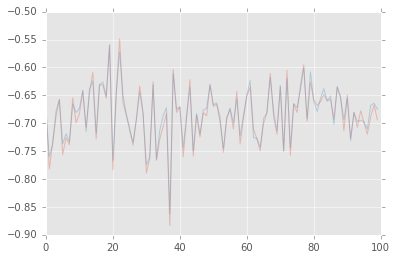

In [29]:
plt.plot(np.log(ans.probability[:100]), alpha=0.3)
plt.plot(np.log(ans_sgd.probability[:100]), alpha=0.3)

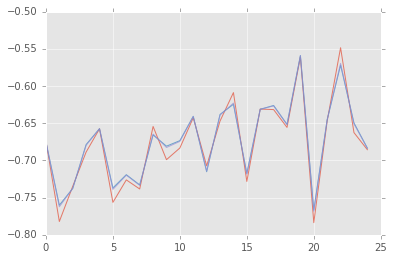

In [78]:
from scipy import ndimage
n = 25

# a: 0.9 : 0.69141
# 0.8: 0.69138
# 0.7: 0.69134
# 0.6: 0.69130
# 0.5: 0.69127
# 0.4: 0.69123
# 0.3: 0.69120
# 0.2: 0.69117
# 0.1: 0.69114

a = 0.1
b = 1-a

filtered = ndimage.filters.gaussian_filter(-ans_sgd.probability, 0.001, mode='mirror')
plt.plot(np.log(ans.probability[:n]), alpha=0.7)
plt.plot(np.log(ans_sgd.probability[:n]), alpha=0.7)
plt.plot(np.log(a * ans.probability[:n] + b * ans_sgd.probability[:n]), alpha=0.7)
# plt.plot(-filtered[:n], alpha=0.7)

new_ans = ans.copy()
new_ans.probability = a * ans.probability + b * ans_sgd.probability
new_ans.to_csv('test_comb_ans.csv', index=False)

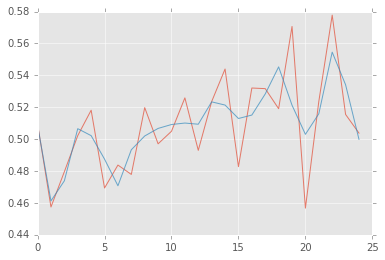

In [125]:
from scipy import signal

smoothed_ans = ans.copy()
smoothed_ans.probability = signal.savgol_filter(ans.probability, 5, 3)

plt.plot(ans.probability[:n], alpha=0.7)
# plt.plot(ans.probability[:n], alpha=0.7)
plt.plot(smoothed_ans.probability[:n],alpha=0.7)


smoothed_ans.to_csv('test_smooth_ans.csv', index=False)

In [14]:
## Sorted with swap

In [126]:
def get_sorted_data_with_swap(data, feature):
    sorted_data = data.sort(columns=feature).copy()
    X = sorted_data.drop('target', axis=1) if 'target' in sorted_data.columns else sorted_data
    y = []
    rows = X.shape[0]
    y = sorted_data['target'] if 'target' in data else []
    for col in X.columns:
        if col == 't_id':
            continue
        feature_swapped = [0. for i in range(rows)] # np.zeros() дает друго результат о_0... хотя отличий быть не должно
        for i in range(rows):
            feature_swapped[i] = X[col][(i - 1) % rows]
        X['prev_' + col] = feature_swapped
    return X, y

def get_sorted_data_with_swap_2cols(data):
    rows = data.shape[0]
    
    sorted_data = data.sort(columns='feature6').copy()
    
    for col in sorted_data.columns:
        if col in ['t_id', 'target']:
            continue
        feature_swapped = [0. for i in range(rows)] # np.zeros() дает друго результат о_0... хотя отличий быть не должно
        for i in range(rows):
            feature_swapped[i] = sorted_data[col][(i - 1) % rows]
        sorted_data['prev_6_' + col] = feature_swapped
        
    sorted_data = sorted_data.sort(columns='feature1').copy()
    for col in sorted_data.columns:
        if col in ['t_id', 'target'] or 'prev' in col:
            continue
        feature_swapped = [0. for i in range(rows)] # np.zeros() дает друго результат о_0... хотя отличий быть не должно
        for i in range(rows):
            feature_swapped[i] = sorted_data[col][(i - 1) % rows]
        sorted_data['prev_1_' + col] = feature_swapped
    
    X = sorted_data.drop('target', axis=1) if 'target' in sorted_data.columns else sorted_data
    y = sorted_data['target'] if 'target' in data else []
    
    return X, y

In [129]:
X, y = get_sorted_data_with_swap(data, ['feature1']) #get_sorted_data_with_swap(data, ['feature6'])
X = normalize_df(X, X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_state)

D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from IPython.kernel.zmq import kernelapp as app


In [24]:
clf_log_reg = LogisticRegression(random_state=random_state, n_jobs=-1, max_iter=1000)

param_grid = {
    'penalty' : ['l1'], # 'l1'
    'C': np.linspace(0.0001, 100.0, 50),
    'tol': [0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10, 100]
}

clf = grid_search_clf(clf_log_reg, param_grid, X_train, y_train, show=True)
print('log_loss: {0}'.format(clf_score(clf, X_test, y_test)))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  4.5min finished


Fitting 3 folds for each of 450 candidates, totalling 1350 fits
best score: -0.691726966376
best estimator:
LogisticRegression(C=2.0409142857142859, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)
log_loss: 0.691997072823


In [ ]:
sgd_clf = SGDClassifier(loss='log', random_state=random_state, n_jobs=-1,
                       n_iter=100)

param_grid = {
    'loss' : ['log', 'modified_huber'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
#     'alpha': np.linspace(0.000001, 0.0001, 50),
    'l1_ratio': [0.001, 0.1, 0.03, 0.07, 0.15, 0.3, 0.5, 0.7, 0.9, 1],
}

clf = grid_search_clf(sgd_clf, param_grid, X_train, y_train, show=True)
print('log_loss: {0}'.format(clf_score(clf, X_test, y_test)))


print "Done with log reg"
print "\n\n==========================\n\n"

In [ ]:
# feature 1: 0.691270907607 - the best
# feature 6: 0.691390394556 - good
# feature 1 with 2 prev: 0.691667414946  - bad
# feature 6 with2 prev: 0.691516171687 -bad
# 19 and 6: log_loss: 0.691607982969 - bad
# feature 19: 0.691901755334 - very bad
# 6 and 19: 0.692073637757 - very very bad

# 0.691887221816

# Попробовать добавить предыдущую 6 и предыдущую 1 фичу совместно
# результат: 0.691730353044 - very bad